1. 데이터 전처리 및 데이터 결합

In [10]:
import pandas as pd

# 파일 경로 정리
# 11-12 ~ 23-24
salary_files = [
    'salary_data/nba_salary_2011-12.csv', 'salary_data/nba_salary_2012-13.csv', 
    'salary_data/nba_salary_2013-14.csv', 'salary_data/nba_salary_2014-15.csv', 
    'salary_data/nba_salary_2015-16.csv', 'salary_data/nba_salary_2016-17.csv',  
    'salary_data/nba_salary_2017-18.csv', 'salary_data/nba_salary_2018-19.csv',  
    'salary_data/nba_salary_2019-20.csv', 'salary_data/nba_salary_2020-21.csv',
    'salary_data/nba_salary_2021-22.csv', 'salary_data/nba_salary_2022-23.csv', 
    'salary_data/nba_salary_2023-24.csv'
]
# 10-11 ~ 22-23
stats_files = [
    'stats_data/nba_stats_2010-11.csv', 'stats_data/nba_stats_2011-12.csv',
    'stats_data/nba_stats_2012-13.csv', 'stats_data/nba_stats_2013-14.csv',
    'stats_data/nba_stats_2014-15.csv', 'stats_data/nba_stats_2015-16.csv', 
    'stats_data/nba_stats_2016-17.csv', 'stats_data/nba_stats_2017-18.csv', 
    'stats_data/nba_stats_2018-19.csv', 'stats_data/nba_stats_2019-20.csv', 
    'stats_data/nba_stats_2020-21.csv', 'stats_data/nba_stats_2021-22.csv',
    'stats_data/nba_stats_2022-23.csv'
]

# 팀명 약어 데이터 로드
team_file = 'other_data/team.csv'
team_data = pd.read_csv(team_file)
team_mapping = team_data.set_index('team')['abbreviation'].to_dict()

# 인플레이션 비율 정의
inflation_rates = {
    2011: 224.939, 2012: 229.594, 2013: 232.957,
    2014: 236.736, 2015: 237.017, 2016: 240.007, 
    2017: 245.120, 2018: 251.107, 2019: 255.657, 
    2020: 258.811, 2021: 270.970, 2022: 292.655,
    2023: 304.702, 2024: 315.664
}
base_inflation = inflation_rates[2024]  # 기준 연도: 2024

# 데이터 병합을 위한 리스트
all_data = []

# 파일들을 시즌별로 처리
for i, (stats_file, salary_file) in enumerate(zip(stats_files, salary_files)):
    try:
        stats_file = stats_files[i]
        season_year = 2011 + i

        # 데이터 로드
        stats_data = pd.read_csv(stats_file)
        salary_data = pd.read_csv(salary_file)

        # 연봉 데이터 팀명을 약어로 변환
        salary_data['TEAM'] = salary_data['TEAM'].map(lambda x: team_mapping.get(x, x))
        
        # 연봉 데이터의 이름에서 포지션 제거
        salary_data['NAME'] = salary_data['NAME'].str.split(',').str[0].str.strip()
        
        # 연봉 데이터의 컬럼명 변경
        salary_data.rename(columns={'NAME':'Player'}, inplace=True)
        
        # 연봉 데이터에서 $ 제거 및 숫자형으로 변환
        salary_data['SALARY'] = salary_data['SALARY'].replace('[\$,]', '', regex=True).astype(int)
        
        # 인플레이션 조정 (소수점 제거)
        current_inflation = inflation_rates.get(season_year, base_inflation)
        salary_data['SALARY_ADJUSTED'] = (salary_data['SALARY'] * (base_inflation / current_inflation)).round(0).astype(int)
        
        # 이름과 팀을 기준으로 병합
        merged_data = pd.merge(
            stats_data, salary_data,
            how='inner',
            left_on=['Player'],
            right_on=['Player']
        )
        
        # 시즌 정보 추가
        merged_data['SEASON'] = f'{season_year}-{season_year+1}'
        
        # 병합된 데이터 추가
        all_data.append(merged_data)
    except Exception as e:
        print(f"Error processing season {season_year}-{season_year+1}: {e}")

# 모든 시즌 데이터를 하나의 데이터프레임으로 결합
final_data = pd.concat(all_data, ignore_index=True)
final_data['SEASON'].value_counts()
print(final_data.duplicated().sum())

SEASON
2012-2013    444
2022-2023    436
2011-2012    435
2021-2022    411
2020-2021    408
2014-2015    406
2016-2017    402
2015-2016    401
2023-2024    400
2019-2020    396
2018-2019    396
2017-2018    373
2013-2014    343
Name: count, dtype: int64

SEASON
2011-2012    35426394
2012-2013    41870301
2013-2014    41265856
2014-2015    31334922
2015-2016    33295502
2016-2017    40724006
2017-2018    48237088
2018-2019    47086999
2019-2020    49674829
2020-2021    52453567
2021-2022    53332114
2022-2023    51849355
2023-2024    53783338
Name: SALARY_ADJUSTED, dtype: int64
SEASON
2011-2012    25244493
2012-2013    30453805
2013-2014    30453805
2014-2015    23500000
2015-2016    25000000
2016-2017    30963450
2017-2018    37457154
2018-2019    37457154
2019-2020    40231758
2020-2021    43006362
2021-2022    45780966
2022-2023    48070014
2023-2024    51915615
Name: SALARY, dtype: int64


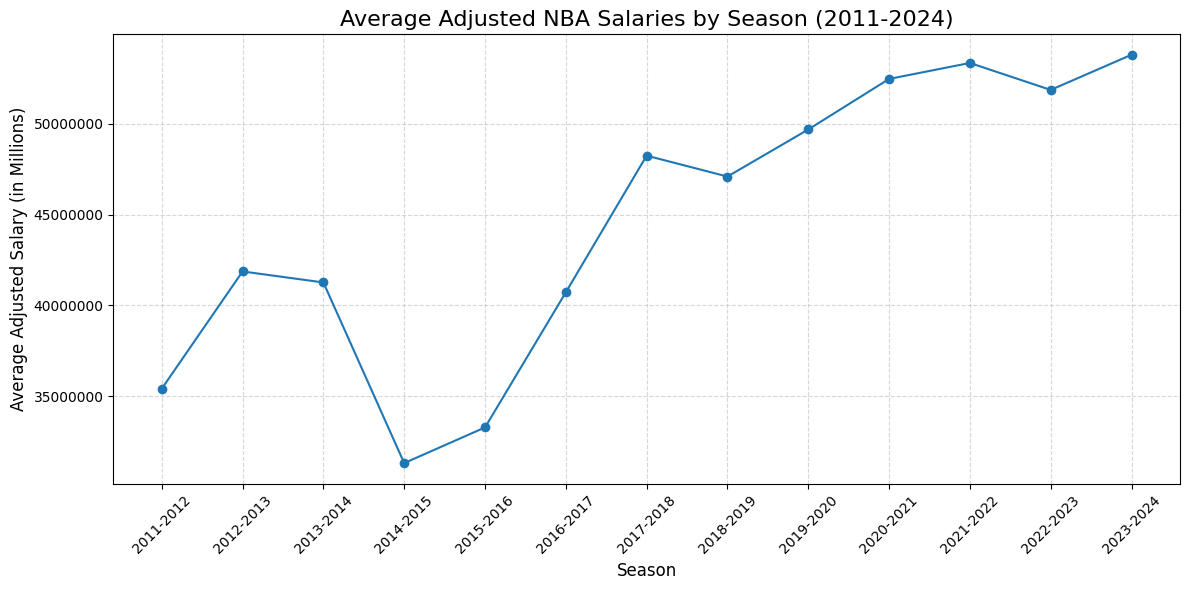

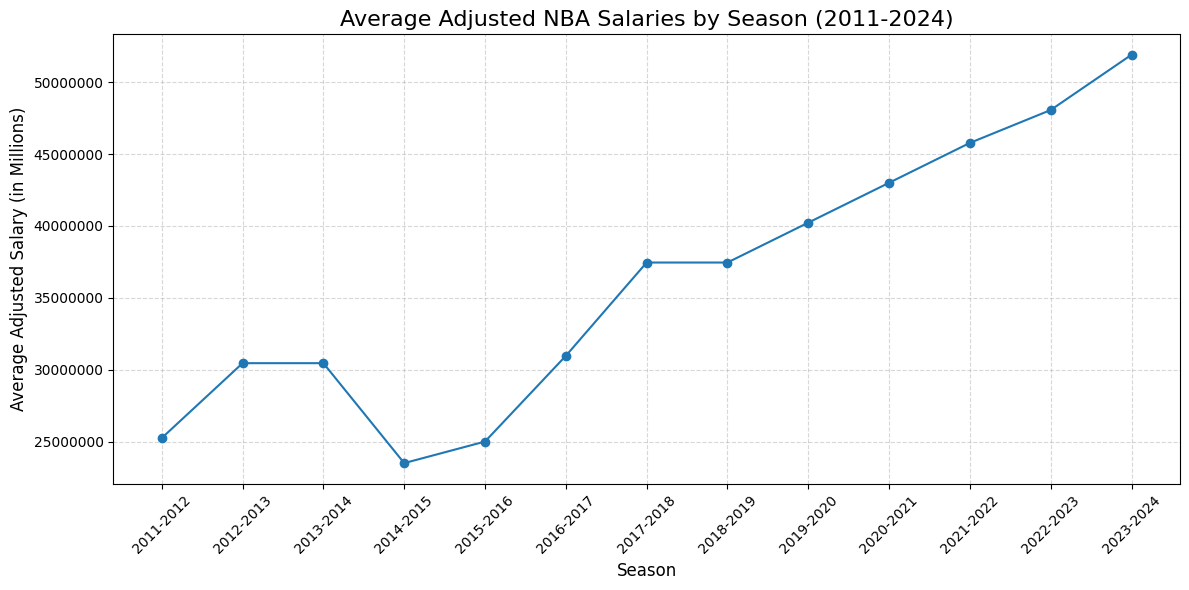

In [9]:
import matplotlib.pyplot as plt

# 시즌별 평균 인플레이션 조정 연봉 계산
avg_salary_by_season = final_data.groupby('SEASON')['SALARY_ADJUSTED'].max().reset_index()
ac = final_data.groupby('SEASON')['SALARY'].max().reset_index()
c = final_data.groupby('SEASON')['SALARY'].max()
a = final_data.groupby('SEASON')['SALARY_ADJUSTED'].max()
print(a)
print(c)
# 시각화
plt.figure(figsize=(12, 6))
plt.plot(avg_salary_by_season['SEASON'], avg_salary_by_season['SALARY_ADJUSTED'], marker='o')
plt.title('Average Adjusted NBA Salaries by Season (2011-2024)', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Adjusted Salary (in Millions)', fontsize=12)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')  # 지수 표현 제거

plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(avg_salary_by_season['SEASON'], ac['SALARY'], marker='o')
plt.title('Average Adjusted NBA Salaries by Season (2011-2024)', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Adjusted Salary (in Millions)', fontsize=12)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')  # 지수 표현 제거

plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()